In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
BASE_PATH = r"D:\Workspace\Project\[Tni]_Project\[CPE305] - Sign Language Translate"
DATA_PATH = os.path.join(BASE_PATH, "Dataset")
LOG_DIR = os.path.join(BASE_PATH, "Logs")
MODEL_SAVE_PATH = 'sign_language_model.keras'
actions = ['กลับ', 'ขอบคุณ', 'คุณสบายดีไหม', 'ช่วย', 'เชื่อ', 'แนะนำ', 'พา', 'รอ', 'สวัสดี', 'อะไร']
# actions = np.array(os.listdir(DATA_PATH)) # หรือใช้แบบนี้เพื่อดึงชื่อโฟลเดอร์อัตโนมัติ
sequence_length = 30
label_map = {label: num for num, label in enumerate(actions)}

In [ ]:


# --- 2. DATA LOADING ---
print("Loading Data...")
sequences, labels = [], []

for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    # ตรวจสอบว่ามีโฟลเดอร์จริงไหม
    if not os.path.exists(action_path):
        print(f"Warning: Folder {action} not found via path {action_path}")
        continue
        
    # วนลูปตามจำนวนโฟลเดอร์ที่มีจริง (ไม่ได้ Hardcode ว่าต้องมี 30 sequence เป๊ะๆ เผื่อบางคำเก็บข้อมูลมาไม่เท่ากัน)
    video_list = os.listdir(action_path) 
    
    for sequence in video_list:
        window = []
        # เช็คว่าไฟล์ครบ 30 เฟรมไหม (Data Consistency Check)
        is_valid_sequence = True
        for frame_num in range(sequence_length):
            npy_path = os.path.join(action_path, sequence, "{}.npy".format(frame_num))
            if not os.path.exists(npy_path):
                is_valid_sequence = False
                break
            res = np.load(npy_path)
            window.append(res)
            
        if is_valid_sequence:
            sequences.append(window)
            labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)

print(f"Total Sequences: {X.shape[0]}")
print(f"Data Shape: {X.shape}")

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.1577 - loss: 2.2804
Epoch 1: val_categorical_accuracy improved from -inf to 0.20000, saving model to sign_language_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - categorical_accuracy: 0.1579 - loss: 2.2793 - val_categorical_accuracy: 0.2000 - val_loss: 2.2385
Epoch 2/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.1716 - loss: 2.2355 
Epoch 2: val_categorical_accuracy did not improve from 0.20000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.1765 - loss: 2.2312 - val_categorical_accuracy: 0.2000 - val_loss: 2.1573
Epoch 3/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.1727 - loss: 2.1839
Epoch 3: val_categorical_accuracy did not improve from 0.20000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.1820 - loss: 2.1758 - val_categorical_accuracy: 0.1833 - val_loss: 2.0759
Epoch 4/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 

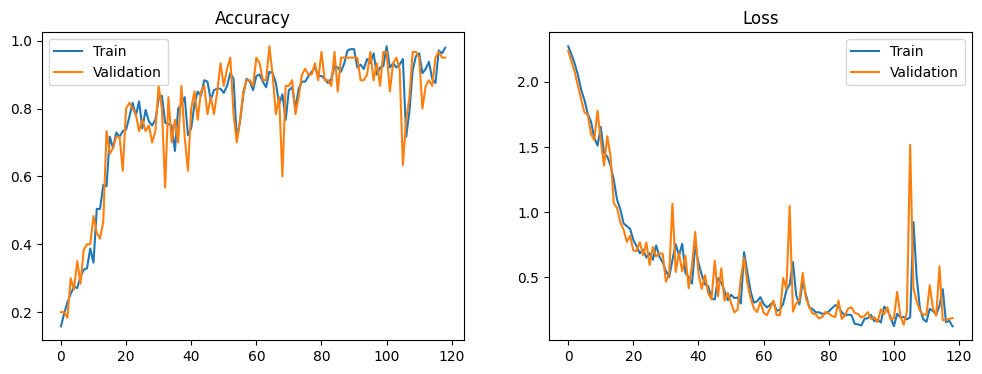

In [ ]:
# --- 3. DATA SPLITTING ---
# ใช้ train_test_split เพื่อสุ่มข้อมูล (Shuffle) ป้องกันโมเดลจำลำดับ
# stratify=y เพื่อให้สัดส่วนของแต่ละท่าใน Train/Test เท่ากัน
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --- 4. MODEL ARCHITECTURE ---
model = Sequential()

# Layer 1: ใช้ activation='tanh' (default) เพื่อให้ใช้ cuDNN ได้
# Input Shape (30, 1662)
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30, 1662)))
model.add(Dropout(0.2)) # ป้องกัน Overfitting

# Layer 2
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

# Layer 3
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dropout(0.2))

# Dense Layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

# --- 5. COMPILATION & CALLBACKS ---
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
tb_callback = TensorBoard(log_dir=LOG_DIR)
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_categorical_accuracy', save_best_only=True, verbose=1)

# --- 6. TRAINING ---
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=200, 
                    batch_size=16, 
                    callbacks=[early_stopping, tb_callback, checkpoint])

# --- 7. EVALUATION ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train')
plt.plot(history.history['val_categorical_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()